# **Capstone II Modeling**

In this section of the data science method we finally use our data to develop a model to predict the temperature of the target room in the house. 

We will use a SARIMAX model, which does everything an ARIMA model can do, which does everything an AR or an MA model can do based on the parameters you pass it. SARIMAX goes beyond ARIMA by accounting for highly seasonal data, which ours is. Both models can handle exogenous data. For comparison we will also use a random forest regressor. 

### Section 1: Imports and Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('../Data/train_scaled_df.csv', parse_dates = ['Unnamed: 0'], index_col = 'Unnamed: 0')
train.index = pd.date_range(start = train.index[0], end = train.index[-1], freq='15min')

test = pd.read_csv('../Data/test_scaled_df.csv', parse_dates = ['Unnamed: 0'], index_col = 'Unnamed: 0')
test.index = pd.date_range(start = test.index[0], end = test.index[-1], freq='15min')

In [3]:
train.head()

,co2_dining_room,co2_room,relative_humidity_dining_room,relative_humidity_room,lighting_dining_room,lighting_room,wind,sun_light_in_west_facade,sun_light_in_east_facade,sun_light_in_south_facade,sun_irradiance,outdoor_relative_humidity,rain_none,rain_rain,sun_dusk_full,sun_dusk_none,sun_dusk_partial,indoor_temperature_room
2012-03-13 11:45:00,1.259658,1.715107,-0.674522,-0.591184,2.293957,1.696829,0.361028,-0.188425,0.005900,2.125555,1.871279,-0.635709,0.235308,-0.235308,0.988756,-0.931342,-0.175412,17.8275
2012-03-13 12:00:00,1.822433,1.462093,-0.672419,-0.612898,2.297159,1.698815,0.510874,-0.136147,-0.076794,2.125555,1.882173,-0.679815,0.235308,-0.235308,0.988756,-0.931342,-0.175412,18.1207
2012-03-13 12:15:00,1.732044,1.229717,-0.695332,-0.615278,2.283843,1.698698,0.781484,-0.020797,-0.127657,2.124431,1.896460,-0.709064,0.235308,-0.235308,0.988756,-0.931342,-0.175412,18.4367
2012-03-13 12:30:00,1.600779,0.922915,-0.694740,-0.631657,2.287087,1.692718,0.724231,0.157841,-0.128635,2.123304,1.895729,-0.740802,0.235308,-0.235308,0.988756,-0.931342,-0.175412,18.7513
2012-03-13 12:45:00,1.451404,0.766102,-0.694784,-0.635509,2.285593,1.685475,1.205828,0.465513,-0.148652,2.123145,1.884476,-0.861350,0.235308,-0.235308,0.988756,-0.931342,-0.175412,19.0414


In [4]:
test.head()

,co2_dining_room,co2_room,relative_humidity_dining_room,relative_humidity_room,lighting_dining_room,lighting_room,wind,sun_light_in_west_facade,sun_light_in_east_facade,sun_light_in_south_facade,sun_irradiance,outdoor_relative_humidity,rain_none,rain_rain,sun_dusk_full,sun_dusk_none,sun_dusk_partial,indoor_temperature_room
2012-04-05 12:30:00,-1.220738,-1.767126,1.679070,1.397576,1.869218,2.051067,2.068257,0.559222,0.488807,1.387201,2.094765,0.581603,0.235308,-0.235308,0.988756,-0.931342,-0.175412,21.1560
2012-04-05 12:45:00,-1.327078,-1.775901,1.675900,1.326943,2.332524,2.334635,2.222543,1.030489,0.438598,1.766622,2.607617,0.577456,0.235308,-0.235308,0.988756,-0.931342,-0.175412,21.3400
2012-04-05 13:00:00,-1.321761,-1.848702,1.697229,1.507108,0.944063,1.419546,1.904317,0.685870,0.309941,0.711389,1.426092,0.435150,0.235308,-0.235308,0.988756,-0.931342,-0.175412,21.5040
2012-04-05 13:15:00,-1.410323,-1.916302,1.740286,1.558982,-0.050365,0.393168,1.888044,0.263852,0.243795,0.082534,0.611519,0.426026,0.235308,-0.235308,0.988756,-0.931342,-0.175412,21.5693
2012-04-05 13:30:00,-1.449370,-2.028915,1.789268,1.523487,0.173063,0.955724,1.732547,0.308552,0.318111,0.041121,0.666906,0.468343,0.235308,-0.235308,0.988756,-0.931342,-0.175412,21.5840


In [5]:
# Split the training and testing sets into independent and dependent variables
X_train, y_train = train.drop(columns = 'indoor_temperature_room'), train['indoor_temperature_room']
X_test, y_test = test.drop(columns = 'indoor_temperature_room'), test['indoor_temperature_room']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2211, 17), (2211,), (553, 17), (553,))

### Section 2: SARIMAX Modeling

### 2.1 Manual Parameters

Based on the acf and pacf functions viewed in previous in the EDA section, we anticipate the best model is of order (p = 0, d = 1, q = 0) and seasonal order (P = 0, D = 1, Q = 1, S = ~100). Let's test these parameters first, then set up a grid search for the most optimal parameters as determined by mean squared error.

In [24]:
# Obtain the "cycle", i.e. the number of data points contained in one season (day) of our data
df = pd.read_csv('../Data/train_cleaned.csv', parse_dates = ['date_time'], index_col = 'date_time')
df.index = pd.date_range(start = df.index[0], end = df.index[-1], freq='15min')

cycle = len(df.loc['2012-03-21 00:00:000': '2012-03-22 00:00:000'])
cycle

97

In [25]:
# Train the model
model = SARIMAX(y_train, exog = X_train, order = (0, 1, 0), seasonal_order = (0, 1, 1, cycle), trend = 'c')

In [26]:
# Fit the model
sarimax1_results = model.fit()

In [10]:
sarimax1_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:              indoor_temperature_room   No. Observations:                 2211
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 97)   Log Likelihood                2276.211
Date:                              Fri, 01 Jul 2022   AIC                          -4512.422
Time:                                      20:02:09   BIC                          -4399.305
Sample:                                  03-13-2012   HQIC                         -4471.003
                                       - 04-05-2012                                         
Covariance Type:                                opg                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
intercept                        -0.0003      0.001     -0.343      0.732      -0.002       0.002
co2_dining_room                   0.0302      0.009      3.392      0.001       0.013       0.048
co2_room                          0.0495      0.006      8.046      0.000       0.037       0.062
relative_humidity_dining_room     0.0834      0.021      3.956      0.000       0.042       0.125
relative_humidity_room           -0.4133      0.023    -18.167      0.000      -0.458      -0.369
lighting_dining_room              0.0007      0.009      0.080      0.937      -0.017       0.018
lighting_room                    -0.0089      0.011     -0.837      0.403      -0.030       0.012
wind                              0.0084      0.005      1.781      0.075      -0.001       0.018
sun_light_in_west_facade          0.0323      0.011      3.023      0.003       0.011       0.053
sun_light_in_east_facade         -0.0761      0.010     -7.308      0.000      -0.096      -0.056
sun_light_in_south_facade         0.0923      0.028      3.285      0.001       0.037       0.147
sun_irradiance                   -0.0501      0.028     -1.778      0.075      -0.105       0.005
outdoor_relative_humidity        -0.0876      0.026     -3.384      0.001      -0.138      -0.037
rain_none                        -0.0002      0.003     -0.052      0.958      -0.006       0.006
rain_rain                        -0.0015      0.003     -0.496      0.620      -0.007       0.004
sun_dusk_full                    -0.0066      0.006     -1.088      0.277      -0.018       0.005
sun_dusk_none                     0.0024      0.006      0.389      0.697      -0.010       0.014
sun_dusk_partial                 -0.0003      0.002     -0.194      0.846      -0.004       0.003
ma.S.L97                         -0.5725      0.016    -35.988      0.000      -0.604      -0.541
sigma2                            0.0067      0.000     56.047      0.000       0.006       0.007
===================================================================================
Ljung-Box (L1) (Q):                1037.92   Jarque-Bera (JB):             18938.82
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.28   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.06e+18. Standard errors may be unstable.
"""

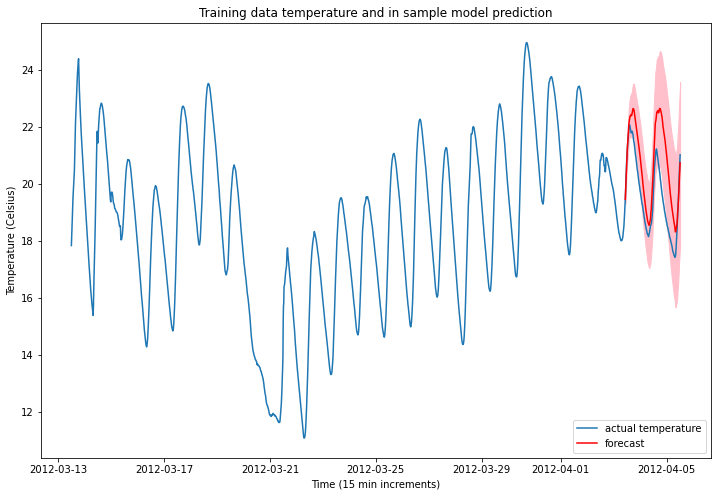

In [11]:
# View the model's forecast of the last 200 periods of the training set
forecast = sarimax1_results.get_prediction(start = -200, dynamic = True)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

plt.figure(figsize = (12, 8))
plt.plot(y_train, label = 'actual temperature')
plt.plot(mean_forecast, color = 'red', label = 'forecast')
plt.fill_between(mean_forecast.index, confidence_intervals['lower indoor_temperature_room'], 
                 confidence_intervals['upper indoor_temperature_room'],
                color = 'pink')
plt.legend(loc = 4)
plt.title('Training data temperature and in sample model prediction')
plt.xlabel('Time (15 min increments)')
plt.ylabel('Temperature (Celsius)')
plt.show()

In [27]:
# Predict test set values
predictions= sarimax1_results.predict(start = len(train), end=(len(train) + len(test) - 1),exog=X_test)

In [13]:
predictions

2012-04-05 12:30:00    21.263010
2012-04-05 12:45:00    21.526521
2012-04-05 13:00:00    21.650478
2012-04-05 13:15:00    21.814963
2012-04-05 13:30:00    21.951845
                         ...    
2012-04-11 05:30:00    22.581836
2012-04-11 05:45:00    22.507059
2012-04-11 06:00:00    22.411356
2012-04-11 06:15:00    22.281088
2012-04-11 06:30:00    22.183733
Freq: 15T, Name: predicted_mean, Length: 553, dtype: float64

In [14]:
predictions.shape, y_test.shape

((553,), (553,))

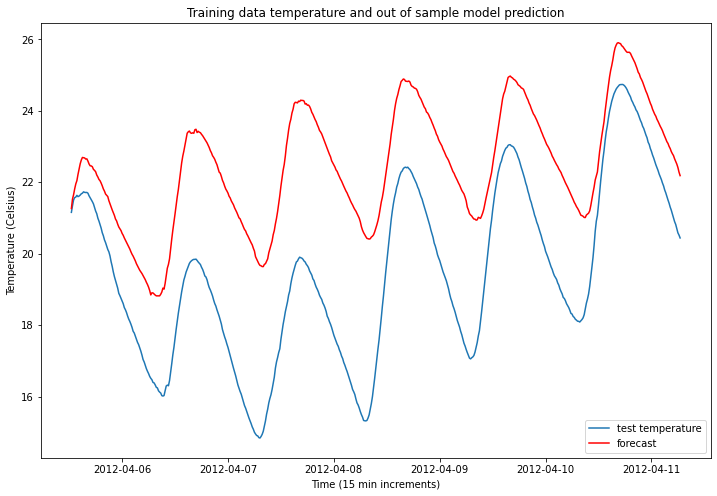

In [15]:
# View the model's forecast of the last 200 periods of the training set
plt.figure(figsize = (12, 8))
plt.plot(y_test, label = 'test temperature')
plt.plot(predictions, color = 'red', label = 'forecast')

plt.legend(loc = 4)
plt.title('Training data temperature and out of sample model prediction')
plt.xlabel('Time (15 min increments)')
plt.ylabel('Temperature (Celsius)')
plt.show()

In [29]:
# Calculate out of sample error metrics
rmse_SARIMAX = mean_squared_error(y_test,predictions, squared = False)
r2_SARIMAX = r2_score(y_test, predictions)

### 2.2 SARIMAX Without Exogenous Variables

Including exogenous variables causes instantiation, fitting, and saving times to take way too long, on the order of 30 minutes each. We'll compare a SARIMAX model without the exogenous variables, using auto_arima. 

pm.auto_arima is a lot like gridsearchCV, only for ARIMA models. From the documentation:

"Automatically discover the optimal order for an ARIMA model.

The auto-ARIMA process seeks to identify the most optimal parameters for an ARIMA model, settling on a single fitted ARIMA model. This process is based on the commonly-used R function, forecast::auto.arima [3].

Auto-ARIMA works by conducting differencing tests (i.e., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto-ARIMA also seeks to identify the optimal P and Q hyper- parameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D.

In order to find the best model, auto-ARIMA optimizes for a given information_criterion, one of (‘aic’, ‘aicc’, ‘bic’, ‘hqic’, ‘oob’) (Akaike Information Criterion, Corrected Akaike Information Criterion, Bayesian Information Criterion, Hannan-Quinn Information Criterion, or “out of bag”–for validation scoring–respectively) and returns the ARIMA which minimizes the value."

https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

Letting auto_arima brute force its default parameters takes far too long and eventuates in a crash. So here we give it some starting parameters we're quite confident in: the data is seasonal, we'll limit the p, P, q, and Q parameters to 3 max, we know the data should be differenced so we'll give it d = 1 and D = 1, and we know the period of seasonality (m = cycle). 

In [17]:
y_train_rounded = y_train.copy()

In [19]:
y_train_rounded = y_train_rounded.round(2)

In [20]:
y_train_rounded.head()

2012-03-13 11:45:00    17.83
2012-03-13 12:00:00    18.12
2012-03-13 12:15:00    18.44
2012-03-13 12:30:00    18.75
2012-03-13 12:45:00    19.04
Freq: 15T, Name: indoor_temperature_room, dtype: float64

In [21]:
# Attempt the auto_arima hyperparameter grid search with rounded data
auto_arima_results = pm.auto_arima(y_train_rounded, m = cycle, error_action = 'ignore', seasonal = True,
                       max_p = 2, d = 1, max_q = 2,
                       max_P = 2, D = 1, maxQ = 2)

MemoryError: Unable to allocate 642. MiB for an array with shape (195, 195, 2212) and data type float64

Unfortunately, using pm.auto_arima to search for model order consistently produced memory errors. We cannot use it without spending more time troubleshooting how to reduce the complexity of our data. We suspect the high seasonality is causing all the slow training and memory errors. Perhaps a SARIMAX model is not an apt model for our data set. 

### Section 3: Random Forest Regression

### 3.1 Untuned Random Forest Regressor

In [7]:
# Try untuned random forest regressor
rf = RandomForestRegressor()

rf.fit(X_train, y_train)

RandomForestRegressor()

In [8]:
# Get predictions
predictions1 = rf.predict(X_test)

In [9]:
# Index predictions by time
predictions_by_time = pd.Series(predictions1, index = y_test.index)

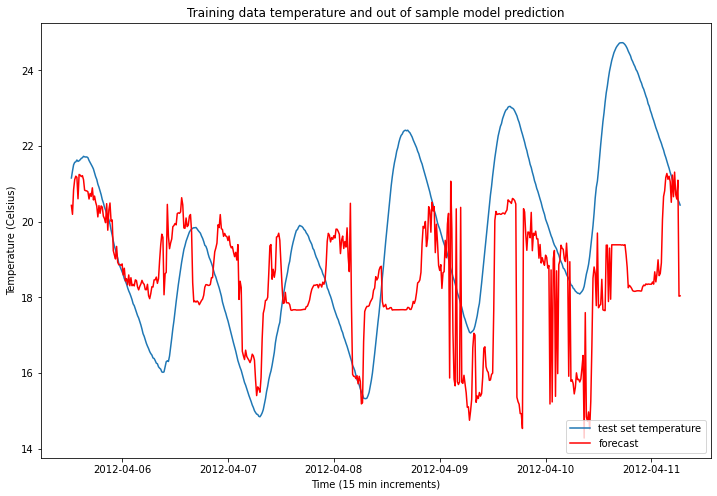

In [10]:
# Plot out of sample predictions
plt.figure(figsize = (12, 8))
plt.plot(y_test, label = 'test set temperature')
plt.plot(predictions_by_time, color = 'red', label = 'forecast')

plt.legend(loc = 4)
plt.title('Training data temperature and out of sample model prediction')
plt.xlabel('Time (15 min increments)')
plt.ylabel('Temperature (Celsius)')
plt.show()

In [11]:
# Calculate out of sample error
rmse_untuned_rf = mean_squared_error(y_test,predictions_by_time, squared = False)
r2_untuned_rf = r2_score(y_test, predictions_by_time)

### 3.2 Tuned Random Forest Regressor

In [12]:
# Create hyperparameter grid
n_estimators = [50, 75, 100, 200, 400, 800, 1000]
max_features = ['auto', 'sqrt']
max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [14]:
# Random search of parameters, using 3 fold cross validation
rf2 = RandomForestRegressor()
rf2_random = RandomizedSearchCV(estimator = rf2, param_distributions = random_grid, 
                                 cv = 3, n_jobs = -1)
# Fit the random search model
rf2_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 75, 100, 200, 400,
                                                         800, 1000]})

In [15]:
# Display best parameters
rf2_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 110,
 'bootstrap': True}

In [17]:
# Extract the best parameters from the random search, get predictions with them, and index by time
best_random = rf2_random.best_estimator_
predictions2 = best_random.predict(X_test)
predictions2_by_time = pd.Series(predictions2, index = y_test.index)

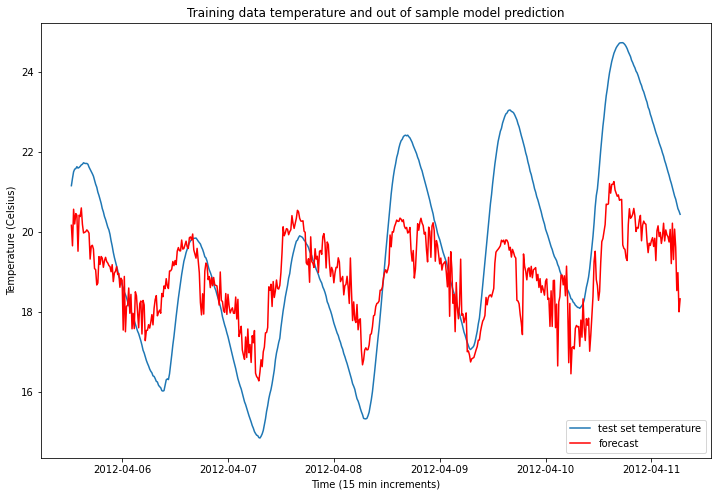

In [19]:
# Plot out of sample predictions
plt.figure(figsize = (12, 8))
plt.plot(y_test, label = 'test set temperature')
plt.plot(predictions2_by_time, color = 'red', label = 'forecast')

plt.legend(loc = 4)
plt.title('Training data temperature and out of sample model prediction')
plt.xlabel('Time (15 min increments)')
plt.ylabel('Temperature (Celsius)')
plt.show()

In [21]:
# Calculate out of sample error
rmse_tuned_rf = mean_squared_error(y_test, predictions2_by_time, squared = False)
r2_tuned_rf = r2_score(y_test, predictions2_by_time)

### Section 4 Error Comparison and Concluding Remarks

In [30]:
# Create dataframe containing all three model error metrics
error_metrics = {'Root Mean Squared Error': [rmse_SARIMAX, rmse_untuned_rf, rmse_tuned_rf], 
                 'R Squared': [r2_SARIMAX, r2_untuned_rf, r2_tuned_rf]}
scoring_df = pd.DataFrame(error_metrics, index = ['SARIMAX', 'untuned_rf', 'tuned_rf'])

In [31]:
scoring_df

,Root Mean Squared Error,R Squared
SARIMAX,3.250394,-0.753973
untuned_rf,2.658995,-0.173778
tuned_rf,1.904903,0.397584


As it turns out, the tuned random forest regressor scored better than the SARIMAX model, despite our meticulous order inspection. And of course, it's no surprise that the tuned random forest regressor scored better than the untuned one. The random forest regressor did not use time as a factor in its predictions, but this does not imply time is an irrelevant factor in predicting temperature in the room of interest. Our expectation going into this project was that a SARIMAX model would score the best when compared to atemporal models. It may have gone that way if not for a significant roadblock which bears discussing.

Our SARIMAX model was order (p = 0, d = 1, q = 0) and (P = 0, D = 1, Q = 1, S = 97). This means we took the first difference, the seasonal difference with a cycle of 97(!!), and found that the acf/pacf plots showed a seasonal moving average order of 1. Determing order by simple inspection may work often, but many data sets can be messy or tricky and difficult to judge the best order. This led us to our main problem: SARIMAX models may not do too well with seasonal data with large seasonal orders (https://github.com/statsmodels/statsmodels/issues/5727). Because SARIMAX models are so slow to train on seasonal time series' with high seasonal orders, we weren't able to run pm.auto_arima, which may have found us more optimal orders than the ones we found by simple inspection. Perhaps a more finely tuned SARIMAX model would have scored higher. 

The tuned random forest regressor ended up with a mse of 1.90 degrees celsius. In the future, we would like to use a Long Short-Term Memory (LTSM) recurrent neural network with Keras. 